In [1]:
import json
import numpy as np
import dicom
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import random

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
def getVolume(patient,patientdict, v_type = 'orig', ty = None):
    es= {}
    ed = {}
    noSL = []
    noMin = []
    noMax = []
    numSlices = 0
    issues = {}
    minframes = []
    maxframes = []
#     print (patientdict)
    for i in patientdict:
        numSlices = len(patientdict.keys())
        if len(patientdict.keys()) < 5:
             print ('Less than five slices')    

        if patientdict[i]['minSL'] is None: 
#             print ('MinSL: ', patientdict[i])
            noSL.append(patientdict[i]['zminframe'])
        else: 
            if patientdict[i]['zmin'] ==0:
#                 print ('zmin: ', patientdict[i])
                noMin.append(patientdict[i]['zminframe'])
            es[patientdict[i]['minSL']] = {'zmin': patientdict[i]['zmin'],
                                          'minST':patientdict[i]['minST'],
                                          'zcounts': patientdict[i]['zcounts']}
            minframes.append([i, patientdict[i]['zminframe']])
    
        if patientdict[i]['maxSL'] is None:
#             print ('MaxSL: ', patientdict[i])
            noSL.append(patientdict[i]['zmaxframe'])
        else:
            if patientdict[i]['zmax'] ==0:
#                 print ('zmax: ', patientdict[i])
                noMax.append(patientdict[i]['zmaxframe'])
            ed[patientdict[i]['maxSL']] = {'zmax': patientdict[i]['zmax'],
                                          'maxST':patientdict[i]['maxST'],
                                          'zcounts': patientdict[i]['zcounts']}
            maxframes.append([i,patientdict[i]['zmaxframe']])
    issues[patient] = {'numSlices': numSlices,
                        'noMinValue': noMin,
                       'noMaxValue': noMax,
                       'noSL': noSL,
                      'minframes': minframes,
                      'maxframes': maxframes}
    
    if v_type == 'orig':
        ESV, EDV = origVolume(es,ed)
        return (ESV, EDV, issues)
    if v_type == 'ST':
        ESV, EDV = STVolume(es,ed)
        return(ESV, EDV, issues)
    if v_type == 'zeros':
        ESV, EDV = zerosVolume(es,ed, ty)
        return (ESV, EDV, issues)
    

In [3]:
def origVolume(es, ed):
    ESV = 0
    EDV = 0
    
    a = sorted(es)
    b = sorted(ed)
    
    for i in range(len(a)-1):
        ESVi = (es[a[i]]['zmin'] + es[a[i+1]]['zmin']) * ((abs(a[i]-a[i+1]))/2)
        
        ESV = ESV + ESVi
    
    for i in range(len(b)-1):
        EDVi = (ed[b[i]]['zmax'] + ed[b[i+1]]['zmax']) * ((abs(b[i] - b[i+1])/2))
        EDV = EDV + EDVi
    
    ESV = ESV / 1000
    EDV = EDV / 1000
    return (ESV, EDV)

In [4]:
def STVolume(es, ed, STway = 'sub'):
    ESV = 0
    EDV = 0
    
    a = sorted(es)
    b = sorted(ed)
    
    if (len(a) > 2) and (len(b) > 2):
        filtered_a = dict((k, es[k]) for k in a[:-1] if k in es)
        filtered_b = dict((k, ed[k]) for k in b[:-1] if k in ed)
    
        ESV, EDV = origVolume(filtered_a,filtered_b)
    
        if STway == 'sub':
            ESVi = (es[a[-2]]['zmin'] + es[a[-1]]['zmin']) * ((abs(a[-2]-a[-1]-es[a[-1]]['minST']))/2)
            EDVi = (ed[b[-2]]['zmax'] + ed[b[-1]]['zmax']) * ((abs(b[-2]-b[-1]-ed[b[-1]]['maxST']))/2)
        if STway == 'add':
            ESVi = (es[a[-2]]['zmin'] + es[a[-1]]['zmin']) * ((abs(a[-2]-a[-1]))/2)
            ESVi = ESVi + (es[a[-1]]['zmin']*es[a[-1]]['minST'])
            EDVi = (ed[b[-2]]['zmax'] + ed[b[-1]]['zmax']) * ((abs(b[-2]-b[-1]))/2)
            EDVi = EDVi + (ed[b[-1]]['zmax']*ed[b[-1]]['maxST'])
        ESV = ESV + (ESVi / 1000)
        EDV = EDV + (EDVi / 1000)
    else:
        if len(a) == 2:
            for i in range(len(a)-1):
#                 print ('a', len(a), len(a-1), i)
                ESVi = (es[a[i]]['zmin'] + es[a[i+1]]['zmin']) * ((abs(a[i]-a[i+1]-es[a[i+1]]['minST']))/2)
            ESV = (ESV + ESVi)/1000
        if len(b) == 2:
            for i in range(len(b)-1):
                EDVi = (ed[b[i]]['zmax'] + ed[b[i+1]]['zmax']) * ((abs(b[i]-b[i+1]-ed[b[i+1]]['maxST']))/2)
            EDV = (EDV + EDVi)/1000
        if len(a) == 1:
            ESV = (es[a[0]]['zmin']*es[a[0]]['minST'])/1000
        if len(b) == 1:
            EDV = (ed[b[0]]['zmax']*ed[b[0]]['maxST'])/1000
    
    return (ESV, EDV)

In [5]:
def zerosVolume(es,ed, ty = None):
    ESV = 0
    EDV = 0
    
    a = sorted(es)
    count = 0 
    for i in range(len(a)):
        count +=1
        if (es[a[i]]['zmin'] == 0) and (count > 1) and (count < len(a)):
            lst = [x for x in es[a[i]]['zcounts'] if x >0]
            print (lst)
            if len(lst) > 0:
                secmin = min(lst)
                es[a[i]].update({'zmin':secmin})
                print (es[a[i]])
            else:
                del es[a[i]]
    b = sorted(ed)
    for i in range(len(b)):
        if ed[b[i]]['zmax'] == 0:
            del ed[b[i]]
    
    if ty is None:
        ESV, EDV = origVolume(es, ed)
    else: 
        ESV, EDV = STVolume(es,ed)
    return (ESV, EDV)     

In [6]:
def computeVolume(path,imgsize, vtype = 'orig', STway = 'sub',ty = None):
    Volumes = {}
    for root, dirs, files in os.walk(path):   

        for i in files:
            if os.path.isfile(root+i):
                if ('_'+str(imgsize)+'.') in i:
                    split = i.split('_')#.strip('.json')
#                     print (split)
                    source = split[0]
                    patient = split[1].strip('.json')
#                     print (source, patient)
                    print (i)
                    patientdict = json.load(open(root + i))
#                     print (patientdict)
        
                    if vtype == 'orig':
                        ESV, EDV, issues = getVolume(patient, patientdict)
                    elif vtype == 'ST':
                        ESV, EDV, issues = getVolume(patient, patientdict, vtype, STway)
                    elif vtype == 'zeros':
                        ESV, EDV, issues = getVolume(patient, patientdict, vtype, ty)

        
                    Volumes[source+'_'+patient] = {'ESV': ESV, 
                                                  'EDV': EDV,
                                                   'issues': issues}
    return Volumes

In [7]:
def getSliceOutliers(Volumes, data = None):
    few_slices = []
    
    for i in Volumes:
        if data is None:
            if ('train') in i:
                p = i.strip('train_')
                if Volumes[i]['issues'][p]['numSlices'] < 5:
                    few_slices.append(p)
            if ('validate') in i: 
                p = i.strip('validate_')
                if Volumes[i]['issues'][p]['numSlices'] < 5:
                    few_slices.append(p)
        elif data == 'train':
            p = i.strip('train_')
            if Volumes[i]['issues'][p]['numSlices'] < 5:
                few_slices.append(p)
        elif data == 'validate':
            p = i.strip('validate_')
            if Volumes[i]['issues'][p]['numSlices'] < 5:
                few_slices.append(p)
            
    return few_slices

In [8]:
def removeOutliers(df, Volumes, data):
    few_slices = getSliceOutliers(Volumes, data)
#     print (few_slices)
    df = df
    for i in range(len(few_slices)):
        df = df.drop(int(few_slices[i]))
    return df

In [9]:
def removeNoVolume(df):
    tmp = df
    all_values = tmp[(tmp['Systole_P'] > 0) & (tmp['Diastole_P'] >0)]

    return all_values

In [10]:
def removeLowHigh(df, dev, val):
    col = val+'_diff'
    tmp = df
    print (tmp.shape)
    orig = tmp.shape[0]
    low_idx = tmp[tmp[col] > dev].index.tolist()
    tmp = tmp[(tmp[col] < dev)]
    print (tmp.shape)
    high_idx = tmp[tmp[col] < -dev].index.tolist()
    tmp = tmp[(tmp[col] > -dev)]
    print (tmp.shape)
    new = tmp.shape[0]
    #print (tmp)
    return (tmp, orig-new, low_idx, high_idx)

In [11]:
def create_df(Volumes):
    train_gt = pd.read_csv('/masvol/data/dsb/train.csv')
    validate_gt = pd.read_csv('/masvol/data/dsb/validate.csv')
    
    train_pred = []
    validate_pred = []

    for i in Volumes:
        if ('train') in i:
            ID = i.strip('train_')
            ESV = Volumes[i]['ESV']
            EDV = Volumes[i]['EDV']
            train_pred.append([int(ID), ESV, EDV])
        if ('validate') in i:
            ID = i.strip('validate_')
            ESV = Volumes[i]['ESV']
            EDV = Volumes[i]['EDV']
            validate_pred.append([int(ID), ESV, EDV])
    train_pred_df = pd.DataFrame(train_pred, columns= ['Id','Systole_P', 'Diastole_P'])
    validate_pred_df = pd.DataFrame(validate_pred, columns= ['Id','Systole_P', 'Diastole_P'])
    
    train_df = pd.concat([train_gt.set_index('Id'),train_pred_df.set_index('Id')], axis=1, join='inner')
    train_df['Systole_diff'] = train_df['Systole'] - train_df['Systole_P']
    train_df['Diastole_diff'] = train_df['Diastole'] - train_df['Diastole_P']
    train_df['EF_P'] = (train_df['Diastole_P']-train_df['Systole_P'])/train_df['Diastole_P']
    train_df['EF'] = (train_df['Diastole']-train_df['Systole'])/train_df['Diastole']
    validate_df = pd.concat([validate_gt.set_index('Id'),validate_pred_df.set_index('Id')], axis=1, join='inner')
    validate_df['Systole_diff'] = validate_df['Systole'] - validate_df['Systole_P']
    validate_df['Diastole_diff'] = validate_df['Diastole'] - validate_df['Diastole_P']
    validate_df['EF_P'] = (validate_df['Diastole_P']-validate_df['Systole_P'])/validate_df['Diastole_P']
    validate_df['EF'] = (validate_df['Diastole']-validate_df['Systole'])/validate_df['Diastole']
    all_df = pd.concat([train_df, validate_df], axis=0)
    
    return (train_df, validate_df, all_df)

In [28]:
def compute_rmse(df, source, val = None):
    if val is None:
        sys = np.sqrt(sklearn.metrics.mean_squared_error(df['Systole'],df['Systole_P']))
        dia = np.sqrt(sklearn.metrics.mean_squared_error(df['Diastole'],df['Diastole_P']))
        ef = np.sqrt(sklearn.metrics.mean_squared_error(df['EF'],df['EF_P']))
#         print (source,': Systole RMSE: ', sys, 'Diastole RMSE: ', dia, ': EF RMSE: ', ef)
        print (source,": ","Systole RMSE: %.2f" % round(sys,2), "ml ", "Diastole RMSE: '%.2f" % round(dia,2),
               "ml ","EF RMSE: %.2f" % (round(ef,2)*100), "%")
        return (round(sys,2),round(dia,2), (round(ef,2)*100))
    elif ('D') in val:
        dia = np.sqrt(sklearn.metrics.mean_squared_error(df['Diastole'],df['Diastole_P']))
        print (source,'Diastole RMSE: ', dia)
    elif ('S') in val:
        sys = np.sqrt(sklearn.metrics.mean_squared_error(df['Systole'],df['Systole_P']))
        print (source,': Systole RMSE: ', sys)
    elif ('E') in val:
        ef = np.sqrt(sklearn.metrics.mean_squared_error(df['EF'],df['EF_P']))
        print (source, ': EF RMSE: ', ef)

In [13]:
def plotting (df, actual, predicted):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[predicted], df[actual],)
    plt.plot(range(len(df[predicted])), range(len(df[actual])), color = 'green')
    plt.xlabel(predicted)
    plt.ylabel(actual)
    plt.xlim(0,600)
    plt.ylim(0, 600)

In [24]:
# Counts the number of predictions that are higher or lower than the actual value
def estimateCheck (df, actual, predicted, dev):
    diff = df[actual]-df[predicted]
#     print (diff)
    if dev == 0: 
        low = diff[diff > 0].count()
        correct = diff[diff == 0].count()
        high = diff[diff < 0].count()
        print (actual,': % Low Estimate:', round((low/len(df)),2)*100, '% Correct Estimate: ', round((correct/len(df)),2)*100,'% High Estimate: ', 
           (round((high/len(df)),2))*100)
        
    else:
        low = diff[diff > dev].count()
        correct = diff[(diff < 5) & (-5 < diff)].count()
        high = diff[diff < -dev].count()
        print (actual,': % Low Estimate:', round((low/len(df)),2)*100, '% Correct Estimate: ', round((correct/len(df)),2)*100,'% High Estimate: ', 
           (round((high/len(df)),2))*100)
        print ('Lows: ', diff.index[diff > dev].tolist())
        print ('Highs: ', diff.index[diff < -dev].tolist())
        
        return (diff.index[diff > dev].tolist(),diff.index[diff < -dev].tolist())
        
    #print ((low/len(df))+(high/len(df))+(correct/len(df)))
    

In [154]:
def display_images_predictions (image_file, pred_file,  num_images=4, image_list=False, random_images=False, orig=None):
    """Function to display images,predictions and overlays of images and predictions.       

    Args:
        image_file(:string):  image file (.npy) with full path.
        pred_file(:string):  prediction file (.npy) with full path.
        image_list (:list, optional) : list images to be displayed, if this field is present then num_images and random_images will be ignored.
        num_images (:int, optional) : number of images to be displayed, default is 4.
        random_images (:boolean, optional) : if True pick images randomly, else display first n images, default is False.
        
    Returns:
       None.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """
    ts = np.load(image_file)
    pred = np.load(pred_file)
    samples, x, y, z = pred.shape
    print ("samples, max, min ", samples, pred.max(), pred.min())
    pred2 = np.round(pred)

    display_list = []
    if image_list == False:
        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
    else:
        display_list = image_list
    count = 0
    for i in display_list:
        if orig is not None:
            print (orig[count])
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(pred2[i].reshape(x, y))
        plt.title('Prediction'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()
        count +=1

In [144]:
# def display_images_two_predictions (image_file, pred_file, pred_file_2, num_images=4, image_list=False, random_images=False):
#     """Function to display images,predictions and overlays of images and predictions.       

#     Args:
#         image_file(:string):  image file (.npy) with full path.
#         pred_file(:string):  prediction file (.npy) with full path.
#         image_list (:list, optional) : list images to be displayed, if this field is present then num_images and random_images will be ignored.
#         num_images (:int, optional) : number of images to be displayed, default is 4.
#         random_images (:boolean, optional) : if True pick images randomly, else display first n images, default is False.
        
#     Returns:
#        None.
    
#     Note:
#         prection file should have the sigmoid outputs (not the rounded values).
#     """
#     ts = np.load(image_file)
#     pred = np.load(pred_file)
#     samples, x, y, z = pred.shape
#     print ("samples, max, min ", samples, pred.max(), pred.min())
#     pred2 = np.round(pred)
#     pred_2 = np.load(pred_file_2)
#     pred3 = np.round(pred_2)

#     display_list = []
#     if image_list == False:
#         if random_images == True:
#             display_list = random.sample(range(0, samples), num_images)
#         else :
#             display_list = [i for i in range (num_images)]
#     else:
#         display_list = image_list

#     for i in display_list:
        
#         f, axs = plt.subplots(2,3,figsize=(5,5))
#         plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
#         plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
#         plt.subplot(132),plt.imshow(pred2[i].reshape(x, y))
#         plt.title('Prediction'), plt.xticks([]), plt.yticks([])
#         plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
#         plt.title('Overlay'), plt.xticks([]), plt.yticks([])
#         plt.subplot(232),plt.imshow(pred3[i].reshape(x, y))
#         plt.title('Prediction'), plt.xticks([]), plt.yticks([])
#         plt.subplot(233),plt.imshow(ts[i].reshape(x, y)), plt.imshow(pred3[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
#         plt.title('Overlay'), plt.xticks([]), plt.yticks([])
#         plt.show()
        

In [156]:
def plot_outlier_imgs(img_file, pred_file, img_txt, v, image, frames):
    idx = []
    
    f = open(img_txt, 'r')
    x = f.readlines()
    f.close()
    imgs = x[0].split(',')
    orig = []
    
    if int(image) <=500:
        t = 'train_'+image
        s = 'train'
    if int(image) > 500:
        t = 'validate_'+image
        s = 'validate'
    f = v[t]['issues'][image][frames]
    for i in range(len(f)):
        idx.append(imgs.index('/opt/output/dsb/norm/1/3/'+s+'/'+image+'/'+f[i][0]+'_'+f[i][1]))
        orig.append('/opt/output/dsb/norm/1/3/'+s+'/'+image+'/'+f[i][0]+'_'+f[i][1])
#     print (len(orig))
#     if range(len(pred_file)) == 1:
    display_images_predictions (image_file, pred_file, image_list = idx, orig=orig)
#     else: 
#         display_images_two_predictions(image_file, pred_file[0], pred_file[1], image_list= idx)
    

In [111]:
path = '/masvol/output/dsb/volume/1/3combined_1_3_0_176_aug_dice/'
# path = '/masvol/output/dsb/volume/1/3combined_1_3_176_aug_dice/'
# path = '/masvol/output/dsb/volume/1/3combined_1_3_0_176_aug_drop_dice/'
# path = '/masvol/output/dsb/volume/1/3combined_drop_1_3/'
# path = '/masvol/output/dsb/volume/1/3combined_1_3_176_aug_drop_dice/'
v1 = computeVolume(path, 176)
v2 = computeVolume(path, 176, vtype='ST')
v3 = computeVolume(path, 176, vtype='ST', STway='add')
v4 = computeVolume(path, 176, vtype='zeros')
v5 = computeVolume(path, 176, vtype='zeros',ty='ST')

train_1_176.json
validate_501_176.json
train_10_176.json
validate_502_176.json
train_100_176.json
validate_503_176.json
train_101_176.json
validate_504_176.json
train_102_176.json
validate_505_176.json
train_103_176.json
validate_506_176.json
validate_507_176.json
validate_508_176.json
train_104_176.json
validate_509_176.json
train_105_176.json
validate_510_176.json
train_106_176.json
validate_511_176.json
train_107_176.json
validate_512_176.json
train_108_176.json
validate_513_176.json
train_109_176.json
validate_514_176.json
train_11_176.json
train_110_176.json
validate_515_176.json
train_111_176.json
train_112_176.json
validate_516_176.json
train_113_176.json
validate_517_176.json
train_114_176.json
validate_518_176.json
train_115_176.json
validate_519_176.json
train_116_176.json
validate_520_176.json
train_117_176.json
validate_521_176.json
train_118_176.json
validate_522_176.json
validate_523_176.json
train_119_176.json
validate_524_176.json
train_12_176.json
validate_525_176.json

train_405_176.json
train_406_176.json
train_407_176.json
train_408_176.json
train_409_176.json
train_41_176.json
train_410_176.json
train_411_176.json
train_412_176.json
train_413_176.json
train_414_176.json
train_415_176.json
train_416_176.json
train_417_176.json
train_418_176.json
train_419_176.json
train_42_176.json
train_420_176.json
train_421_176.json
train_422_176.json
train_423_176.json
train_424_176.json
train_425_176.json
train_426_176.json
train_427_176.json
train_428_176.json
train_429_176.json
train_43_176.json
train_430_176.json
train_431_176.json
train_432_176.json
train_433_176.json
train_434_176.json
train_435_176.json
train_436_176.json
train_437_176.json
train_438_176.json
train_439_176.json
train_44_176.json
train_440_176.json
train_441_176.json
train_442_176.json
train_443_176.json
train_444_176.json
train_445_176.json
train_446_176.json
train_447_176.json
train_448_176.json
train_449_176.json
train_45_176.json
train_450_176.json
train_451_176.json
train_452_176.jso

validate_683_176.json
train_265_176.json
validate_684_176.json
train_266_176.json
validate_685_176.json
train_267_176.json
train_268_176.json
validate_686_176.json
validate_687_176.json
train_269_176.json
validate_688_176.json
train_27_176.json
train_270_176.json
validate_689_176.json
train_271_176.json
validate_690_176.json
validate_691_176.json
train_272_176.json
train_273_176.json
validate_692_176.json
train_274_176.json
validate_693_176.json
train_275_176.json
validate_694_176.json
train_276_176.json
validate_695_176.json
validate_696_176.json
train_277_176.json
validate_697_176.json
train_278_176.json
validate_698_176.json
validate_699_176.json
train_279_176.json
validate_700_176.json
train_28_176.json
train_280_176.json
train_281_176.json
train_282_176.json
train_283_176.json
train_284_176.json
train_285_176.json
train_286_176.json
train_287_176.json
train_288_176.json
train_289_176.json
train_29_176.json
train_290_176.json
train_291_176.json
train_292_176.json
train_293_176.json

train_264_176.json
validate_683_176.json
train_265_176.json
validate_684_176.json
train_266_176.json
validate_685_176.json
train_267_176.json
train_268_176.json
validate_686_176.json
validate_687_176.json
train_269_176.json
validate_688_176.json
train_27_176.json
train_270_176.json
validate_689_176.json
train_271_176.json
validate_690_176.json
validate_691_176.json
train_272_176.json
train_273_176.json
validate_692_176.json
train_274_176.json
validate_693_176.json
train_275_176.json
validate_694_176.json
train_276_176.json
validate_695_176.json
validate_696_176.json
train_277_176.json
validate_697_176.json
train_278_176.json
validate_698_176.json
validate_699_176.json
train_279_176.json
validate_700_176.json
train_28_176.json
train_280_176.json
train_281_176.json
train_282_176.json
train_283_176.json
train_284_176.json
train_285_176.json
train_286_176.json
train_287_176.json
train_288_176.json
train_289_176.json
train_29_176.json
train_290_176.json
train_291_176.json
train_292_176.json

validate_562_176.json
[1672, 2237, 2158, 620, 1096, 1276, 503, 1688, 1621, 1516, 2149, 2122, 1753, 131, 1046, 2150, 1533, 991, 1918, 1670, 2118, 1034, 890, 1994, 1612, 747, 820, 1664]
{'zcounts': [1672, 2237, 2158, 620, 1096, 1276, 0, 503, 1688, 1621, 1516, 2149, 2122, 1753, 131, 1046, 2150, 1533, 991, 1918, 1670, 2118, 1034, 890, 0, 1994, 1612, 747, 820, 1664], 'zmin': 131, 'minST': 8.0}
[310, 64, 202, 549, 41, 18, 984, 898, 4, 769, 819, 277, 955, 735, 779, 26, 1007, 14, 30, 602, 2, 51]
{'zcounts': [310, 64, 0, 0, 0, 202, 0, 549, 41, 18, 0, 984, 0, 898, 4, 0, 769, 819, 277, 955, 735, 779, 26, 1007, 14, 30, 602, 2, 0, 51], 'zmin': 2, 'minST': 8.0}
train_154_176.json
validate_563_176.json
[535, 738, 245, 731, 805, 502, 833, 310, 269, 48, 819, 676, 181, 716, 733, 774, 451, 843, 186, 637, 785, 254, 337, 744, 336, 66, 708, 387, 22]
{'zcounts': [535, 0, 738, 245, 731, 805, 502, 833, 310, 269, 48, 819, 676, 181, 716, 733, 774, 451, 843, 186, 637, 785, 254, 337, 744, 336, 66, 708, 387, 22], '

validate_698_176.json
validate_699_176.json
[515, 382, 215, 431, 327, 396, 456, 427, 341, 127, 253, 379, 383, 494, 391, 18, 502]
{'zcounts': [515, 382, 215, 431, 0, 327, 396, 0, 0, 456, 0, 0, 0, 0, 0, 427, 341, 0, 0, 127, 253, 0, 0, 379, 383, 494, 0, 391, 18, 502], 'zmin': 18, 'minST': 6.0}
[126, 5, 194, 337, 427, 59, 190, 179, 281, 940, 202, 497, 15, 450, 978, 210, 807, 318, 116, 166, 129, 141, 59, 976, 80, 359]
{'zcounts': [126, 5, 194, 337, 427, 59, 190, 179, 281, 0, 940, 202, 497, 15, 0, 450, 978, 210, 807, 318, 116, 166, 129, 0, 0, 141, 59, 976, 80, 359], 'zmin': 5, 'minST': 6.0}
[40, 6, 9, 10, 74, 101, 145]
{'zcounts': [0, 0, 0, 40, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 10, 0, 0, 0, 74, 0, 0, 0, 0, 0, 101, 145], 'zmin': 6, 'minST': 6.0}
[6, 36, 161, 48, 227, 26, 61, 46, 185, 233, 38, 188, 85, 280, 164, 12, 323, 340, 16, 103, 10]
{'zcounts': [6, 36, 161, 0, 48, 227, 26, 0, 0, 61, 46, 0, 185, 0, 233, 38, 188, 0, 85, 280, 164, 12, 323, 340, 16, 103, 0, 0, 0, 10], 'zmin': 6, 'min

train_1_176.json
[205, 159, 261, 167, 248, 247, 248, 256, 216, 217, 178, 259, 244, 243, 170, 235, 216, 260, 255]
{'zcounts': [0, 205, 159, 261, 0, 167, 0, 0, 248, 247, 0, 248, 256, 0, 216, 217, 178, 259, 244, 243, 170, 235, 216, 0, 0, 0, 0, 260, 0, 255], 'zmin': 159, 'minST': 6.0}
validate_501_176.json
train_10_176.json
[2610, 1467, 2077, 2623, 1966, 2181, 2020, 2353, 1246, 1151, 1859, 1983, 1607, 2562, 1061, 2008, 1487, 2417, 2022, 986, 1088, 1039, 1313, 1985, 1881, 1641, 1061, 1705, 2543]
{'zcounts': [2610, 1467, 2077, 2623, 1966, 2181, 2020, 0, 2353, 1246, 1151, 1859, 1983, 1607, 2562, 1061, 2008, 1487, 2417, 2022, 986, 1088, 1039, 1313, 1985, 1881, 1641, 1061, 1705, 2543], 'zmin': 986, 'minST': 8.0}
validate_502_176.json
train_100_176.json
[24, 1158, 2182, 2017, 1358, 889, 317, 1517, 1170, 1901, 1918, 1745, 1, 2161, 1365, 1387, 995, 1039, 1561, 1111, 2121]
{'zcounts': [24, 1158, 2182, 2017, 1358, 889, 0, 317, 1517, 0, 1170, 0, 1901, 1918, 1745, 1, 0, 2161, 1365, 1387, 0, 995, 1039,

validate_651_176.json
[27, 51, 14, 21, 47, 16, 26, 28, 26, 26, 21, 11, 19, 45, 23, 17, 106, 35, 17, 115]
{'zcounts': [0, 27, 51, 14, 0, 21, 47, 16, 0, 0, 26, 0, 28, 26, 26, 21, 11, 0, 0, 19, 45, 0, 23, 0, 17, 106, 0, 35, 17, 115], 'zmin': 11, 'minST': 6.0}
[253, 158, 10, 19, 18, 16, 12, 30, 5, 242, 320, 284, 282, 251, 124, 7, 289, 14, 265, 168, 116, 213, 335, 160]
{'zcounts': [253, 0, 158, 10, 19, 0, 18, 16, 0, 12, 30, 5, 242, 320, 284, 282, 251, 124, 0, 7, 289, 14, 265, 168, 0, 0, 116, 213, 335, 160], 'zmin': 5, 'minST': 6.0}
train_236_176.json
validate_652_176.json
[1578, 1504, 233, 1457, 960, 235, 1316, 1051, 1573, 346, 1543, 263, 1220, 1580, 1373, 1182, 1549, 1480, 80, 52, 73, 1120, 1511, 175, 956, 243, 611]
{'zcounts': [1578, 1504, 233, 1457, 960, 235, 1316, 0, 1051, 1573, 346, 1543, 263, 1220, 1580, 1373, 0, 1182, 1549, 1480, 80, 52, 73, 1120, 1511, 175, 0, 956, 243, 611], 'zmin': 52, 'minST': 8.0}
train_237_176.json
[2040, 2073, 306, 1934, 103, 30, 2029, 2408, 69, 2018, 2086, 18

train_465_176.json
[761, 778, 895, 5, 526, 838, 848, 653, 657, 893, 263, 744, 906, 763, 111]
{'zcounts': [761, 778, 895, 5, 526, 838, 848, 0, 653, 0, 0, 0, 0, 0, 657, 893, 0, 0, 0, 0, 0, 0, 263, 744, 0, 906, 0, 763, 0, 111], 'zmin': 5, 'minST': 6.0}
[994, 1037, 1090, 539, 890, 607, 1028, 1246, 917, 1137, 1230, 1215, 1147, 1190, 1115, 1119, 825, 1184, 1196, 1043, 1263]
{'zcounts': [994, 0, 0, 1037, 1090, 0, 0, 539, 890, 607, 0, 1028, 1246, 917, 1137, 1230, 1215, 1147, 1190, 0, 1115, 1119, 0, 0, 0, 825, 1184, 1196, 1043, 1263], 'zmin': 539, 'minST': 6.0}
[295, 73, 228, 229, 396, 694, 499, 135, 22, 715, 173, 556, 677, 202]
{'zcounts': [0, 295, 0, 0, 73, 0, 0, 228, 0, 0, 0, 229, 396, 694, 499, 0, 0, 0, 135, 22, 715, 173, 556, 677, 0, 202, 0, 0, 0, 0], 'zmin': 22, 'minST': 6.0}
train_466_176.json
train_467_176.json
[129, 1066, 871, 877, 1454, 2131, 1985, 30, 1945, 618, 2175, 865, 2163, 1912, 2088, 69, 1719, 1490]
{'zcounts': [0, 129, 1066, 871, 877, 0, 0, 0, 1454, 0, 2131, 0, 1985, 30, 0, 1

In [106]:
print ('Original Volume Calculation')
train_df, validate_df, all_df = create_df(v1)
all_remove_noVol = removeNoVolume(all_df)
compute_rmse(all_remove_noVol, 'Tr + Val - Zero Vol')
all_no_outliers = removeOutliers(all_df,v1, data=None)
compute_rmse(all_no_outliers,'Tr + Val - Out')
all_no_out_noVol = removeNoVolume(all_no_outliers)
compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol')
v1_sys_low, v1_sys_high = estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=50)
v1_dia_low, v1_dia_high = estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=50)
#plotting(all_no_out_noVol, actual = 'Systole',predicted = 'Systole_P')

Original Volume Calculation
Tr + Val - Zero Vol :  Systole RMSE: 16.28 ml  Diastole RMSE: '22.44 ml  EF RMSE: 8.00 %
Tr + Val - Out :  Systole RMSE: 15.84 ml  Diastole RMSE: '20.86 ml  EF RMSE: 8.00 %
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.84 ml  Diastole RMSE: '20.86 ml  EF RMSE: 8.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  35.0 % High Estimate:  1.0
Lows:  [82, 269, 478, 579]
Highs:  [298, 352, 429, 630, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  25.0 % High Estimate:  3.0
Lows:  [269]
Highs:  [47, 148, 229, 298, 315, 339, 362, 371, 429, 432, 467, 503, 561, 618, 630, 643, 688, 692]


samples, max, min  450 1.0 0.0


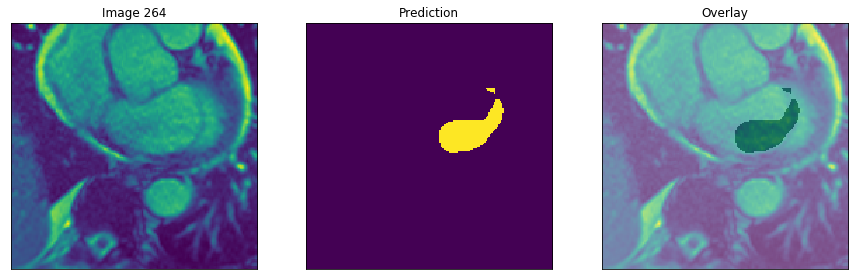

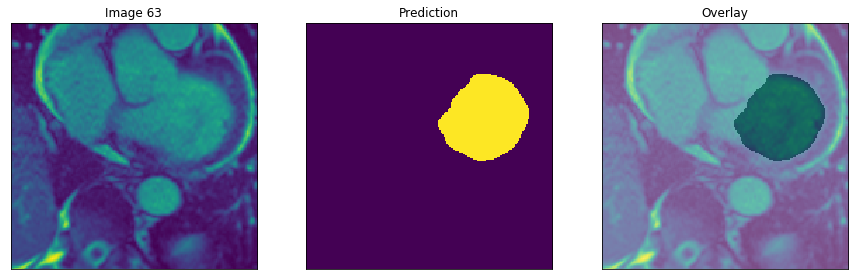

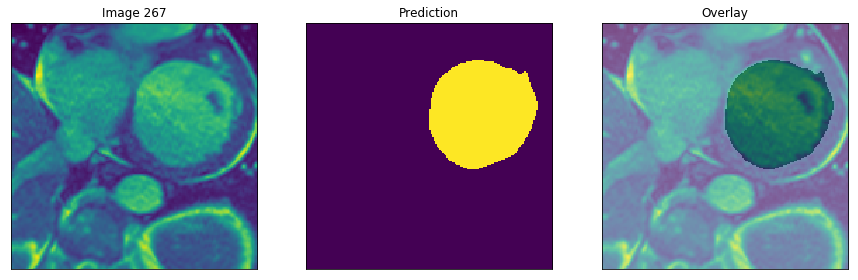

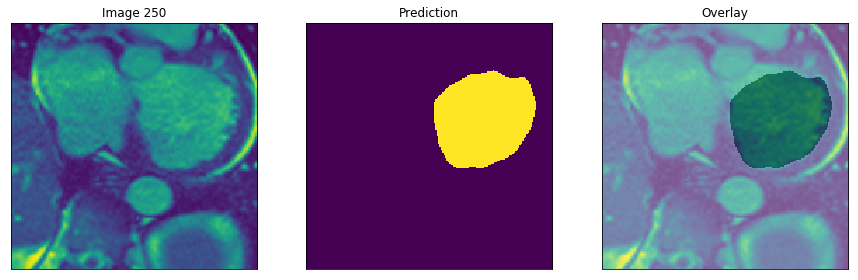

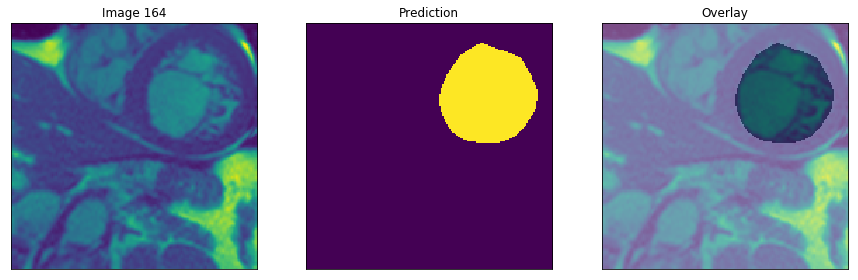

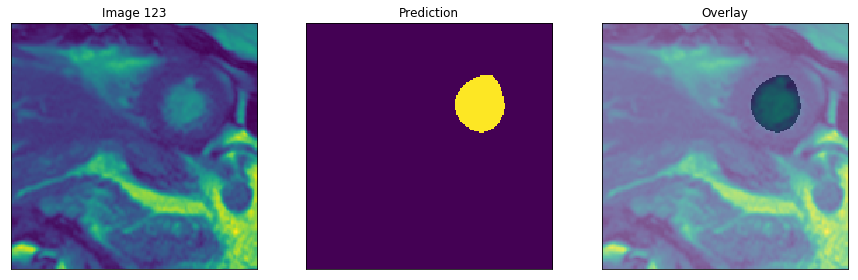

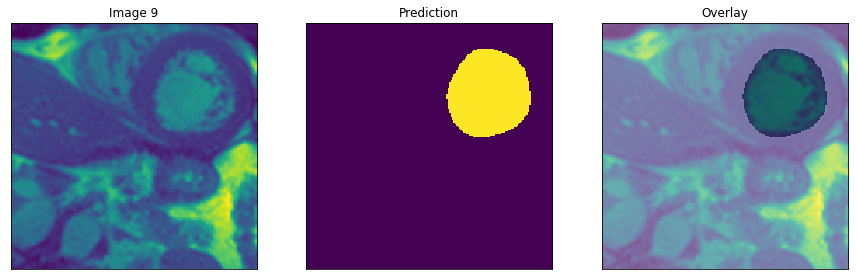

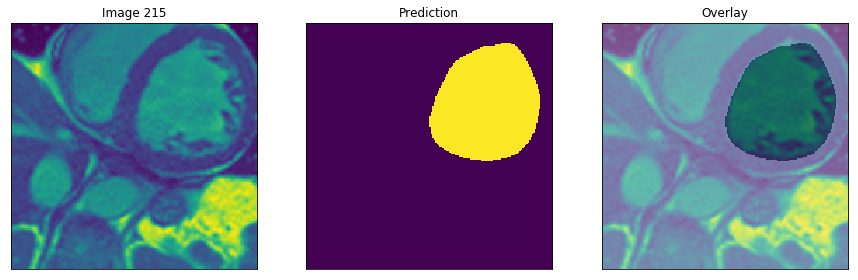

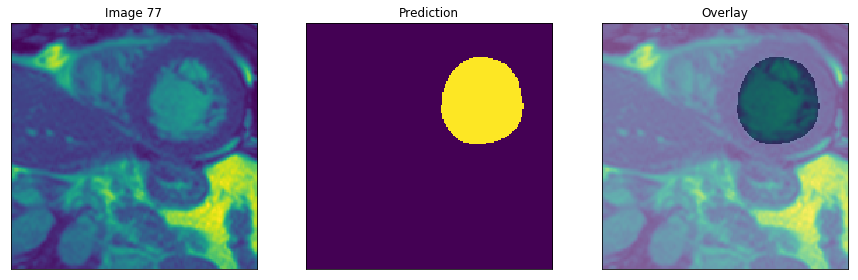

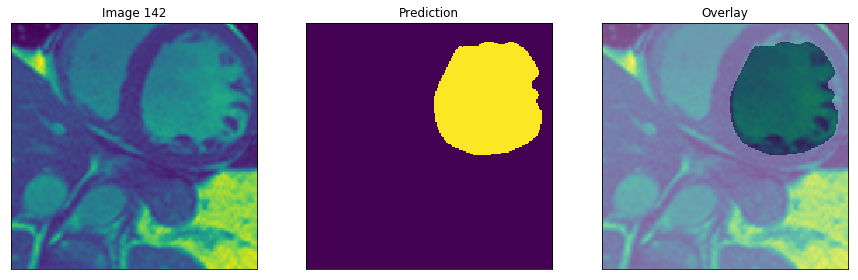

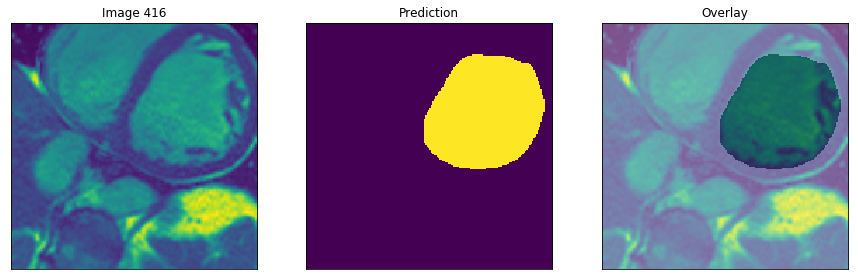

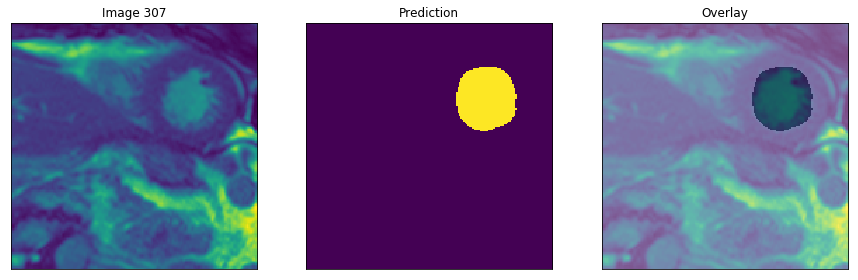

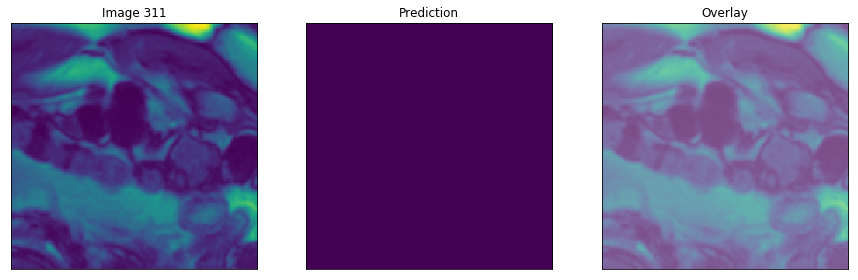

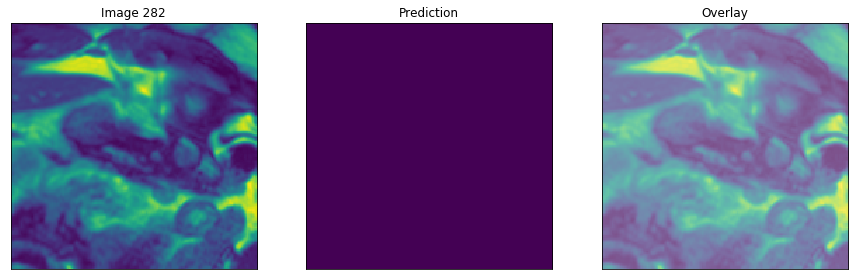

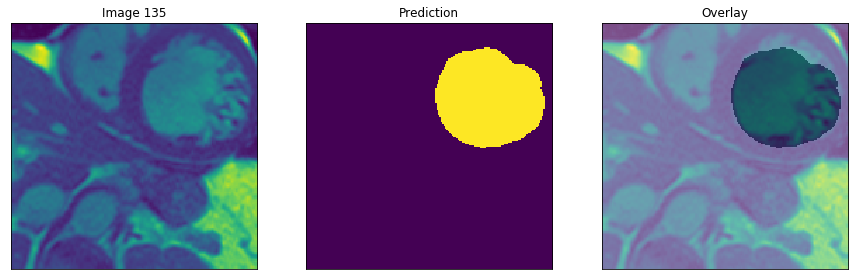

In [107]:
image_file = "/masvol/output/dsb/norm/1/3/unet_model_train/data/dsb_269_176_train.npy"
pred_file = "/masvol/output/dsb/norm/1/3/unet_model_train/combined_1_3_0_176_aug_dice_predict/dsb_269_176_predictions.npy"
img_txt = '/masvol/output/dsb/norm/1/3/unet_model_train/data/dsb_269_image_path.txt'
plot_outlier_imgs(image_file, pred_file, img_txt, v1, image = '269', frames = 'minframes')

In [20]:
print ('ST Volume Calculation')
train_df, validate_df, all_df = create_df(v2)
all_remove_noVol = removeNoVolume(all_df)
compute_rmse(all_remove_noVol, 'Tr + Val - Zero Vol')
all_no_outliers = removeOutliers(all_df,v2, data=None)
compute_rmse(all_no_outliers,'Tr + Val - Out')
all_no_out_noVol = removeNoVolume(all_no_outliers)
compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol')
estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=0)
estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=0)

ST Volume Calculation
Tr + Val - Zero Vol :  Systole RMSE: 16.61 ml  Diastole RMSE: '25.49 ml  EF RMSE: 10.00 %
Tr + Val - Out :  Systole RMSE: 15.94 ml  Diastole RMSE: '24.01 ml  EF RMSE: 9.00 %
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.94 ml  Diastole RMSE: '24.01 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 51.0 % Correct Estimate:  0.0 % High Estimate:  49.0
Diastole : % Low Estimate: 22.0 % Correct Estimate:  0.0 % High Estimate:  78.0


In [21]:
print ('ST Add Volume Calculation')
train_df, validate_df, all_df = create_df(v3)
all_remove_noVol = removeNoVolume(all_df)
compute_rmse(all_remove_noVol, 'Tr + Val - Zero Vol')
all_no_outliers = removeOutliers(all_df,v3, data=None)
compute_rmse(all_no_outliers,'Tr + Val - Out')
all_no_out_noVol = removeNoVolume(all_no_outliers)
compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol')
estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=0)
estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=0)

ST Add Volume Calculation
Tr + Val - Zero Vol :  Systole RMSE: 16.61 ml  Diastole RMSE: '25.49 ml  EF RMSE: 10.00 %
Tr + Val - Out :  Systole RMSE: 15.94 ml  Diastole RMSE: '24.01 ml  EF RMSE: 9.00 %
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.94 ml  Diastole RMSE: '24.01 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 51.0 % Correct Estimate:  0.0 % High Estimate:  49.0
Diastole : % Low Estimate: 22.0 % Correct Estimate:  0.0 % High Estimate:  78.0


In [22]:
print ('Zeros Volume Calculation')
train_df, validate_df, all_df = create_df(v4)
all_remove_noVol = removeNoVolume(all_df)
compute_rmse(all_remove_noVol, 'Tr + Val - Zero Vol')
all_no_outliers = removeOutliers(all_df,v4, data=None)
compute_rmse(all_no_outliers,'Tr + Val - Out')
all_no_out_noVol = removeNoVolume(all_no_outliers)
compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol')
estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=0)
estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=0)

Zeros Volume Calculation
Tr + Val - Zero Vol :  Systole RMSE: 16.49 ml  Diastole RMSE: '22.06 ml  EF RMSE: 9.00 %
Tr + Val - Out :  Systole RMSE: 15.76 ml  Diastole RMSE: '19.86 ml  EF RMSE: 9.00 %
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.76 ml  Diastole RMSE: '19.86 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 56.00000000000001 % Correct Estimate:  0.0 % High Estimate:  44.0
Diastole : % Low Estimate: 52.0 % Correct Estimate:  0.0 % High Estimate:  48.0


In [23]:
print ('Zeros + ST Volume Calculation')
train_df, validate_df, all_df = create_df(v5)
all_remove_noVol = removeNoVolume(all_df)
compute_rmse(all_remove_noVol, 'Tr + Val - Zero Vol')
all_no_outliers = removeOutliers(all_df,v5, data=None)
compute_rmse(all_no_outliers,'Tr + Val - Out')
all_no_out_noVol = removeNoVolume(all_no_outliers)
compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol')
estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=0)
estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=0)

Zeros + ST Volume Calculation
Tr + Val - Zero Vol :  Systole RMSE: 16.61 ml  Diastole RMSE: '25.49 ml  EF RMSE: 9.00 %
Tr + Val - Out :  Systole RMSE: 15.94 ml  Diastole RMSE: '24.01 ml  EF RMSE: 9.00 %
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.94 ml  Diastole RMSE: '24.01 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 49.0 % Correct Estimate:  0.0 % High Estimate:  51.0
Diastole : % Low Estimate: 22.0 % Correct Estimate:  0.0 % High Estimate:  78.0


In [100]:
path_lst = ['/masvol/output/dsb/volume/1/3combined_1_3_0_176_aug_dice/', '/masvol/output/dsb/volume/1/3combined_1_3_176_aug_dice/',
           '/masvol/output/dsb/volume/1/3combined_1_3_0_176_aug_drop_dice/','/masvol/output/dsb/volume/1/3combined_1_3_176_aug_drop_dice/',
           '/masvol/output/dsb/volume/1/3combined_drop_1_3/']
lst = []
for i in range(len(path_lst)):
    v = computeVolume(path_lst[i], 176)
    train_df, validate_df, all_df = create_df(v)
    #all_remove_noVol = removeNoVolume(all_df)
    all_no_outliers = removeOutliers(all_df,v, data=None)
    all_no_out_noVol = removeNoVolume(all_no_outliers)
    sys_rmse, dia_rmse, ef_rmse = compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol' )
    v_sys_low, v_sys_high = estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=50)
    v_dia_low, v_dia_high = estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=50)
    lst.append([path_lst[i], sys_rmse, dia_rmse, ef_rmse,[-50,50], v_sys_low, v_sys_high, v_dia_low, v_dia_high])
voldf = pd.DataFrame(lst, columns=['path','Systole RMSE','Diastole RMSE','EF RMSE','Dev Range',
                                  'Low Systole','High Systole','Low Diastole', 'High Diastole'])

train_1_176.json
validate_501_176.json
train_10_176.json
validate_502_176.json
train_100_176.json
validate_503_176.json
train_101_176.json
validate_504_176.json
train_102_176.json
validate_505_176.json
train_103_176.json
validate_506_176.json
validate_507_176.json
validate_508_176.json
train_104_176.json
validate_509_176.json
train_105_176.json
validate_510_176.json
train_106_176.json
validate_511_176.json
train_107_176.json
validate_512_176.json
train_108_176.json
validate_513_176.json
train_109_176.json
validate_514_176.json
train_11_176.json
train_110_176.json
validate_515_176.json
train_111_176.json
train_112_176.json
validate_516_176.json
train_113_176.json
validate_517_176.json
train_114_176.json
validate_518_176.json
train_115_176.json
validate_519_176.json
train_116_176.json
validate_520_176.json
train_117_176.json
validate_521_176.json
train_118_176.json
validate_522_176.json
validate_523_176.json
train_119_176.json
validate_524_176.json
train_12_176.json
validate_525_176.json

train_392_176.json
train_393_176.json
train_394_176.json
train_395_176.json
train_396_176.json
train_397_176.json
train_398_176.json
train_399_176.json
train_4_176.json
train_40_176.json
train_400_176.json
train_401_176.json
train_402_176.json
train_403_176.json
train_404_176.json
train_405_176.json
train_406_176.json
train_407_176.json
train_408_176.json
train_409_176.json
train_41_176.json
train_410_176.json
train_411_176.json
train_412_176.json
train_413_176.json
train_414_176.json
train_415_176.json
train_416_176.json
train_417_176.json
train_418_176.json
train_419_176.json
train_42_176.json
train_420_176.json
train_421_176.json
train_422_176.json
train_423_176.json
train_424_176.json
train_425_176.json
train_426_176.json
train_427_176.json
train_428_176.json
train_429_176.json
train_43_176.json
train_430_176.json
train_431_176.json
train_432_176.json
train_433_176.json
train_434_176.json
train_435_176.json
train_436_176.json
train_437_176.json
train_438_176.json
train_439_176.json

train_223_176.json
validate_623_176.json
train_224_176.json
validate_624_176.json
train_225_176.json
validate_625_176.json
train_226_176.json
validate_626_176.json
train_227_176.json
validate_627_176.json
train_228_176.json
validate_628_176.json
train_229_176.json
validate_629_176.json
train_23_176.json
validate_630_176.json
train_230_176.json
validate_631_176.json
train_231_176.json
validate_632_176.json
train_232_176.json
validate_633_176.json
train_233_176.json
validate_634_176.json
train_234_176.json
Less than five slices
Less than five slices
train_235_176.json
validate_635_176.json
train_236_176.json
validate_636_176.json
validate_637_176.json
train_237_176.json
train_238_176.json
validate_638_176.json
validate_639_176.json
train_239_176.json
validate_640_176.json
train_24_176.json
validate_641_176.json
train_240_176.json
validate_642_176.json
train_241_176.json
validate_643_176.json
train_242_176.json
validate_644_176.json
validate_645_176.json
train_243_176.json
validate_646_17

train_1_176.json
train_10_176.json
train_100_176.json
train_101_176.json
train_102_176.json
validate_501_176.json
train_103_176.json
validate_502_176.json
train_104_176.json
validate_503_176.json
train_105_176.json
train_106_176.json
validate_504_176.json
train_107_176.json
validate_505_176.json
train_108_176.json
validate_506_176.json
train_109_176.json
validate_507_176.json
train_11_176.json
validate_508_176.json
train_110_176.json
validate_509_176.json
validate_510_176.json
train_111_176.json
train_112_176.json
validate_511_176.json
train_113_176.json
validate_512_176.json
train_114_176.json
validate_513_176.json
train_115_176.json
validate_514_176.json
train_116_176.json
validate_515_176.json
train_117_176.json
train_118_176.json
validate_516_176.json
train_119_176.json
validate_517_176.json
train_12_176.json
validate_518_176.json
train_120_176.json
validate_519_176.json
train_121_176.json
validate_520_176.json
train_122_176.json
validate_521_176.json
validate_522_176.json
train_12

train_428_176.json
train_429_176.json
train_43_176.json
train_430_176.json
train_431_176.json
train_432_176.json
train_433_176.json
train_434_176.json
train_435_176.json
train_436_176.json
train_437_176.json
train_438_176.json
train_439_176.json
train_44_176.json
train_440_176.json
train_441_176.json
train_442_176.json
train_443_176.json
train_444_176.json
train_445_176.json
train_446_176.json
train_447_176.json
train_448_176.json
train_449_176.json
train_45_176.json
train_450_176.json
train_451_176.json
train_452_176.json
train_453_176.json
train_454_176.json
train_455_176.json
train_456_176.json
train_457_176.json
train_458_176.json
train_459_176.json
train_46_176.json
train_460_176.json
train_461_176.json
train_462_176.json
train_463_176.json
train_464_176.json
train_465_176.json
train_466_176.json
train_467_176.json
train_468_176.json
train_469_176.json
train_47_176.json
train_470_176.json
train_471_176.json
train_472_176.json
train_473_176.json
train_474_176.json
train_475_176.jso

train_146_176.json
validate_585_176.json
validate_586_176.json
validate_587_176.json
train_147_176.json
validate_588_176.json
validate_589_176.json
train_148_176.json
validate_590_176.json
validate_591_176.json
validate_592_176.json
train_149_176.json
validate_593_176.json
train_15_176.json
validate_594_176.json
validate_595_176.json
Less than five slices
Less than five slices
Less than five slices
validate_596_176.json
train_150_176.json
validate_597_176.json
Less than five slices
validate_598_176.json
validate_599_176.json
Less than five slices
Less than five slices
Less than five slices
train_151_176.json
validate_600_176.json
validate_601_176.json
train_152_176.json
validate_602_176.json
validate_603_176.json
train_153_176.json
validate_604_176.json
validate_605_176.json
train_154_176.json
validate_606_176.json
validate_607_176.json
validate_608_176.json
train_155_176.json
validate_609_176.json
validate_610_176.json
train_156_176.json
validate_611_176.json
validate_612_176.json
val

In [160]:
low_sys = voldf['Low Diastole'].values
low_sys

array([list([269]), list([269]), list([]), list([]),
       list([75, 172, 208, 237, 262, 269, 276, 279, 280, 478, 545])],
      dtype=object)

samples, max, min  300 1.0 0.0
/opt/output/dsb/norm/1/3/train/127/sax_53_IM-8859-0015.dcm.npy


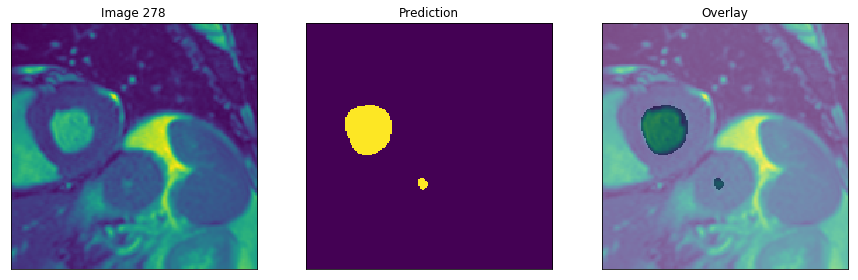

/opt/output/dsb/norm/1/3/train/127/sax_58_IM-8864-0011.dcm.npy


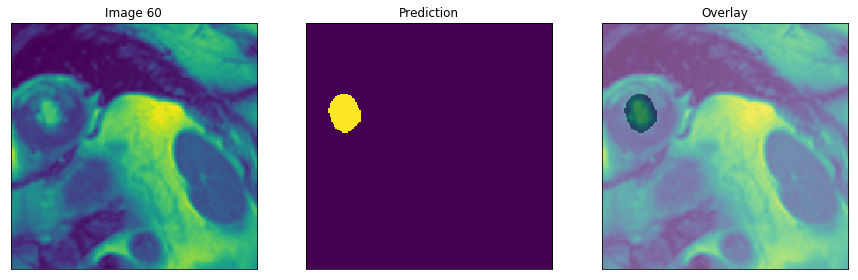

/opt/output/dsb/norm/1/3/train/127/sax_57_IM-8863-0014.dcm.npy


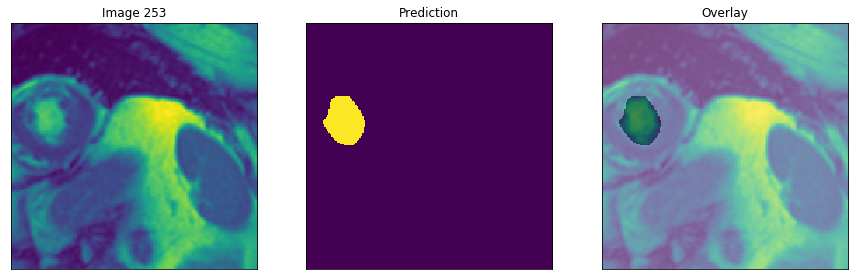

/opt/output/dsb/norm/1/3/train/127/sax_56_IM-8862-0013.dcm.npy


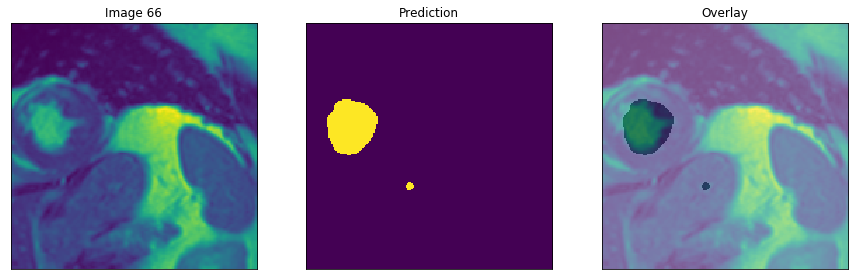

/opt/output/dsb/norm/1/3/train/127/sax_51_IM-8857-0010.dcm.npy


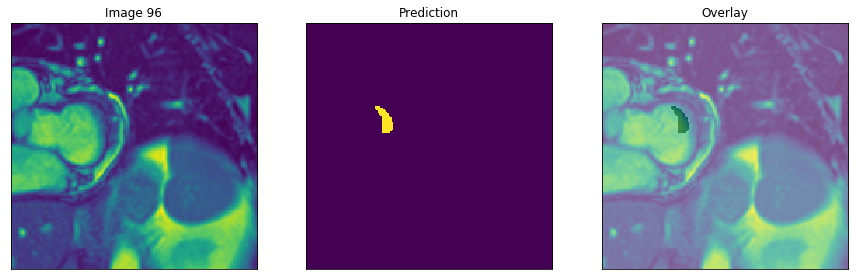

/opt/output/dsb/norm/1/3/train/127/sax_55_IM-8861-0014.dcm.npy


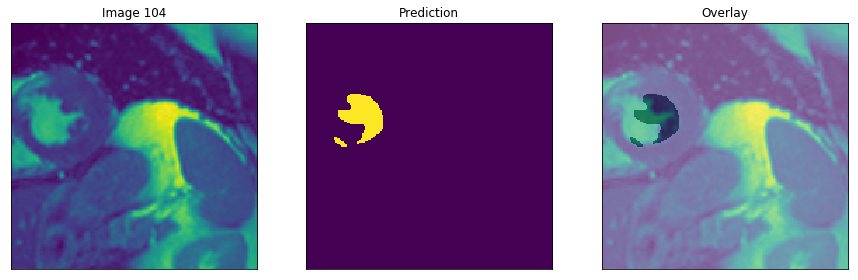

/opt/output/dsb/norm/1/3/train/127/sax_50_IM-8856-0005.dcm.npy


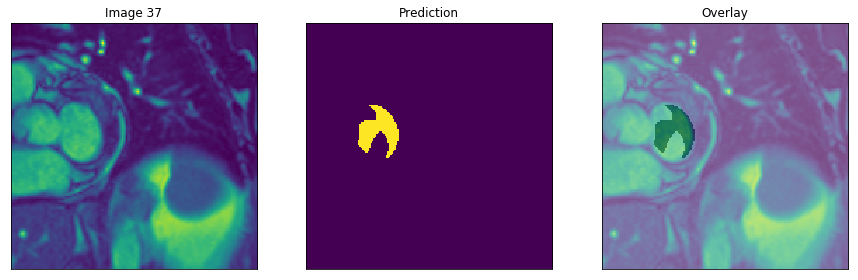

/opt/output/dsb/norm/1/3/train/127/sax_54_IM-8860-0015.dcm.npy


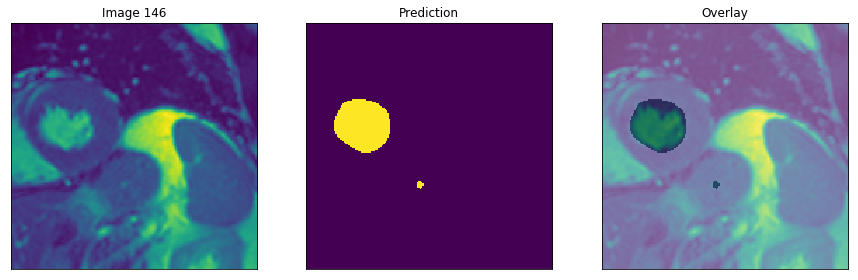

/opt/output/dsb/norm/1/3/train/127/sax_52_IM-8858-0015.dcm.npy


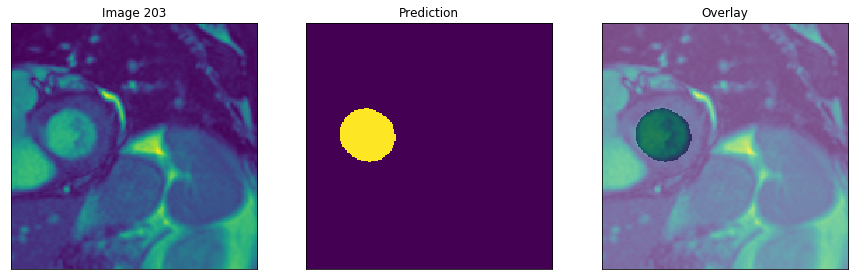

/opt/output/dsb/norm/1/3/train/127/sax_59_IM-8865-0016.dcm.npy


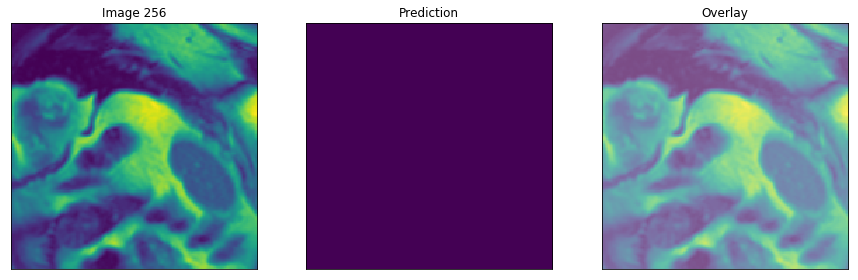

In [157]:
image_file = "/masvol/output/dsb/norm/1/3/unet_model_train/data/dsb_127_176_train.npy"
pred_file = "/masvol/output/dsb/norm/1/3/unet_model_train/combined_1_3_176_aug_dice_predict/dsb_127_176_predictions.npy"
img_txt = '/masvol/output/dsb/norm/1/3/unet_model_train/data/dsb_127_image_path.txt'
plot_outlier_imgs(image_file, pred_file, img_txt, v1, image = '127', frames = 'minframes')

10
samples, max, min  300 1.0 0.0
/opt/output/dsb/norm/1/3/train/127/sax_53_IM-8859-0015.dcm.npy


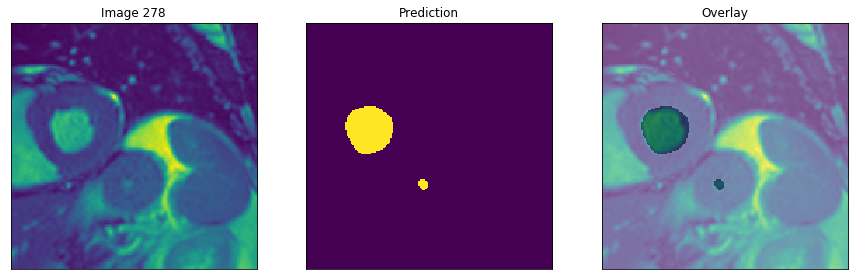

/opt/output/dsb/norm/1/3/train/127/sax_58_IM-8864-0011.dcm.npy


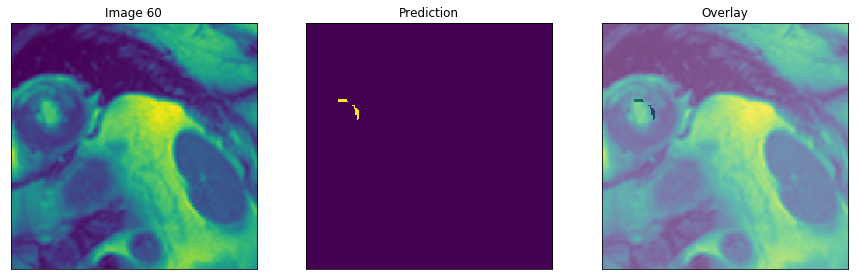

/opt/output/dsb/norm/1/3/train/127/sax_57_IM-8863-0014.dcm.npy


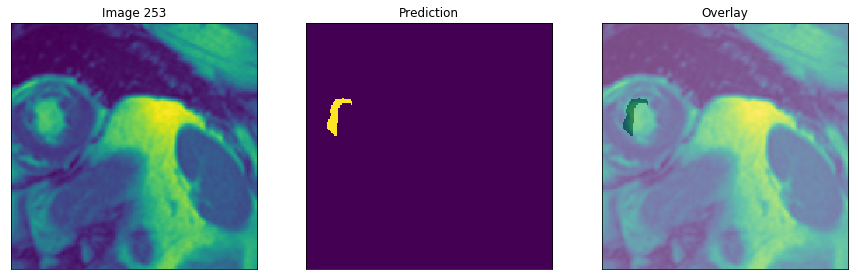

/opt/output/dsb/norm/1/3/train/127/sax_56_IM-8862-0013.dcm.npy


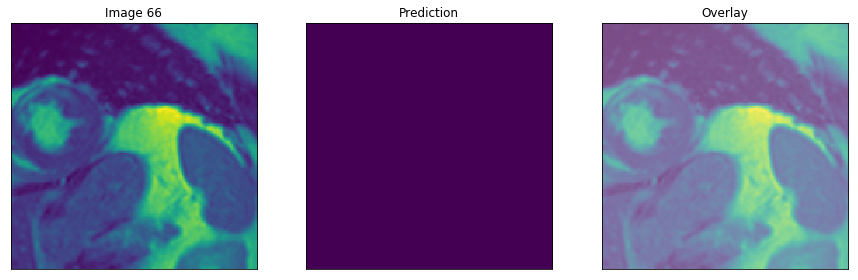

/opt/output/dsb/norm/1/3/train/127/sax_51_IM-8857-0010.dcm.npy


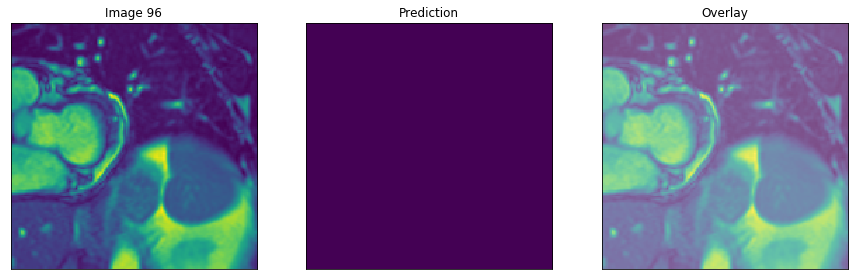

/opt/output/dsb/norm/1/3/train/127/sax_55_IM-8861-0014.dcm.npy


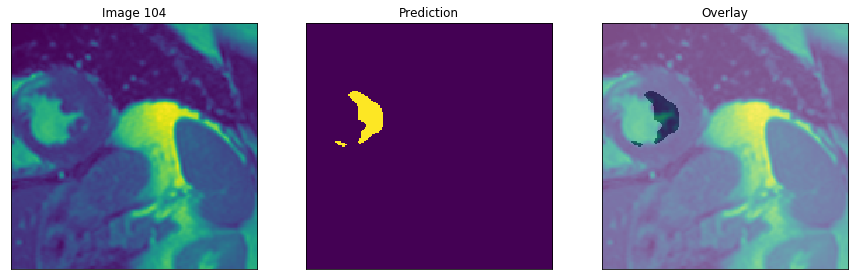

/opt/output/dsb/norm/1/3/train/127/sax_50_IM-8856-0005.dcm.npy


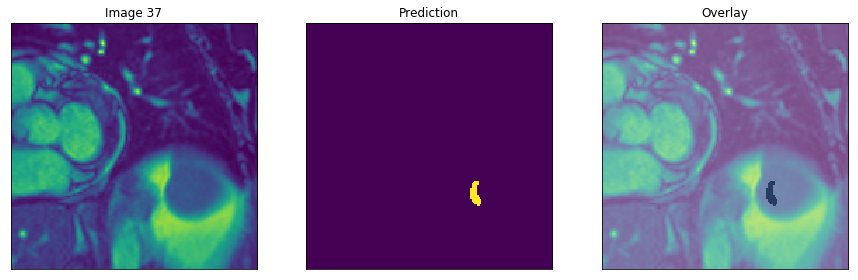

/opt/output/dsb/norm/1/3/train/127/sax_54_IM-8860-0015.dcm.npy


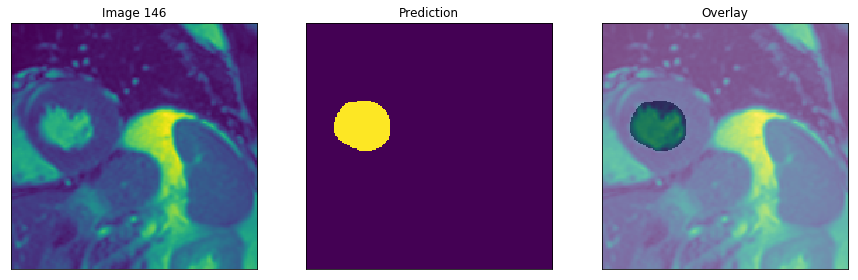

/opt/output/dsb/norm/1/3/train/127/sax_52_IM-8858-0015.dcm.npy


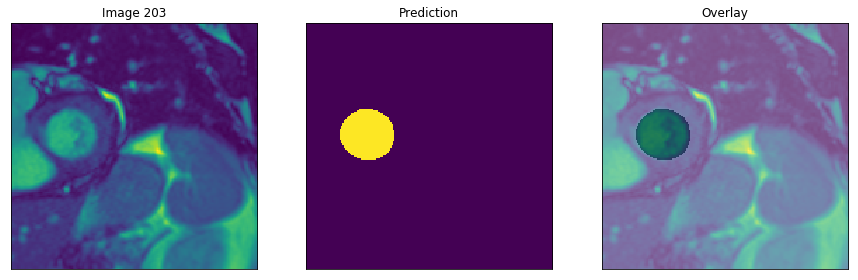

/opt/output/dsb/norm/1/3/train/127/sax_59_IM-8865-0016.dcm.npy


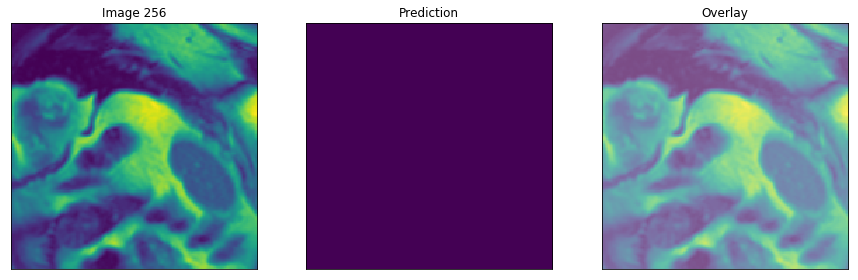

In [155]:
image_file = "/masvol/output/dsb/norm/1/3/unet_model_train/data/dsb_127_176_train.npy"
pred_file = "/masvol/output/dsb/norm/1/3/unet_model_train/combined_1_3_0_176_aug_dice_predict/dsb_127_176_predictions.npy"
img_txt = '/masvol/output/dsb/norm/1/3/unet_model_train/data/dsb_127_image_path.txt'
plot_outlier_imgs(image_file, pred_file, img_txt, v1, image = '127', frames = 'minframes')